              mean_price   final_price
timestamp                             
2023-12-06  44105.944773  44105.944773
2023-12-07  43788.288808  43788.288808
2023-12-08  43270.119560  43270.119560
2023-12-09  44202.176109  44202.176109
2023-12-10  43745.491992  43745.491992


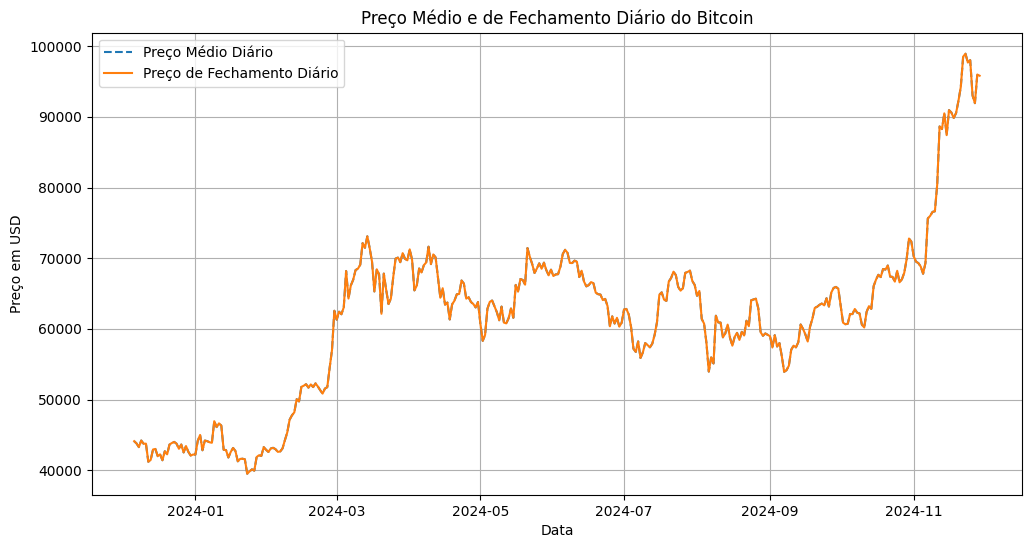

In [1]:

import requests
import pandas as pd
import matplotlib.pyplot as plt

def fetch_bitcoin_data(days=90):
    # Configurações da API da CoinGecko
    url = "https://api.coingecko.com/api/v3/coins/bitcoin/market_chart"
    params = {
        'vs_currency': 'usd',
        'days': str(days)
    }

    # Fazer requisição para a API
    response = requests.get(url, params=params)
    data = response.json()

    # Verificar se os dados foram retornados corretamente
    if 'prices' in data:
        # Criar DataFrame com os preços
        df = pd.DataFrame(data['prices'], columns=['timestamp', 'close'])
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        df.set_index('timestamp', inplace=True)

        # Reordenar colunas
        df = df[['close']]
        return df
    else:
        print("Erro ao obter dados:", data)
        return None

# Coletar dados
df = fetch_bitcoin_data(360)

# Agregar dados para obter o preço médio e final diário
df_daily = df.resample('D').agg({'close': ['mean', 'last']})
df_daily.columns = ['mean_price', 'final_price']  # Renomear colunas

# Exibir os primeiros dados agregados
print(df_daily.head())

# Plotar o gráfico
plt.figure(figsize=(12, 6))
plt.plot(df_daily.index, df_daily['mean_price'], label='Preço Médio Diário', linestyle='--')
plt.plot(df_daily.index, df_daily['final_price'], label='Preço de Fechamento Diário', linestyle='-')
plt.xlabel('Data')
plt.ylabel('Preço em USD')
plt.title('Preço Médio e de Fechamento Diário do Bitcoin')
plt.legend()
plt.grid(True)
plt.show()

# Função para validar e limpar dados


In [2]:

# Função para adicionar novas variáveis derivadas
def add_features(df):
    df['rolling_mean'] = df['close'].rolling(window=7).mean()  # Média móvel de 7 dias
    df['volatility'] = df['close'].rolling(window=7).std()    # Volatilidade
    df = df.dropna()  # Remover valores nulos gerados pelas janelas
    return df

# Aplicando engenharia de features
feature_data = add_features(df)
print("Novas features adicionadas:")
print(feature_data.head())


Novas features adicionadas:
                   close  rolling_mean   volatility
timestamp                                          
2023-12-12  41200.962726  43438.706272  1031.363127
2023-12-13  41450.819387  43059.402646  1216.665372
2023-12-14  42931.761826  42937.041648  1173.446449
2023-12-15  43009.595456  42899.823919  1165.224331
2023-12-16  41992.014187  42584.086502  1046.952157


In [3]:

from sklearn.preprocessing import MinMaxScaler

# Função para normalizar dados
def normalize_data(df):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df[['close', 'rolling_mean', 'volatility']].values)
    return scaled_data, scaler

scaled_data, scaler = normalize_data(feature_data)
print("Dados normalizados com sucesso!")


Dados normalizados com sucesso!


In [4]:

import numpy as np
from keras import Sequential
from keras.src.layers import LSTM, Dense, Dropout

# Função para criar conjuntos de dados
def create_dataset(data, look_back=60):
    X, Y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i + look_back, :])
        Y.append(data[i + look_back, 0])  # Prever o preço de fechamento
    return np.array(X), np.array(Y)

# Criando datasets
look_back = 60
X, Y = create_dataset(scaled_data, look_back)
X_train, Y_train = X[:int(len(X) * 0.8)], Y[:int(len(Y) * 0.8)]
X_test, Y_test = X[int(len(X) * 0.8):], Y[int(len(Y) * 0.8):]

# Construção e treinamento do modelo
def build_and_train_model(X_train, Y_train, X_test, Y_test, epochs=50, batch_size=32):
    model = Sequential([
        LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.2),
        LSTM(units=100),
        Dropout(0.2),
        Dense(units=1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, Y_test))
    return model, history

model, history = build_and_train_model(X_train, Y_train, X_test, Y_test)
print("Modelo treinado com sucesso!")


Epoch 1/50


C:\Code\ia\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - loss: 0.0946 - val_loss: 0.0351
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0106 - val_loss: 0.0337
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0057 - val_loss: 0.0100
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0056 - val_loss: 0.0338
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0054 - val_loss: 0.0179
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0051 - val_loss: 0.0197
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0042 - val_loss: 0.0249
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0035 - val_loss: 0.0188
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0041 - val_loss: 0.0217
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0040 - val_loss: 0.0205
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0041 - val_loss: 0.0204
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0040 - val_loss: 0.0191
Epoch 13/50

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 289ms/step
RMSE: 5012.813602636888, MAE: 3727.136266258186


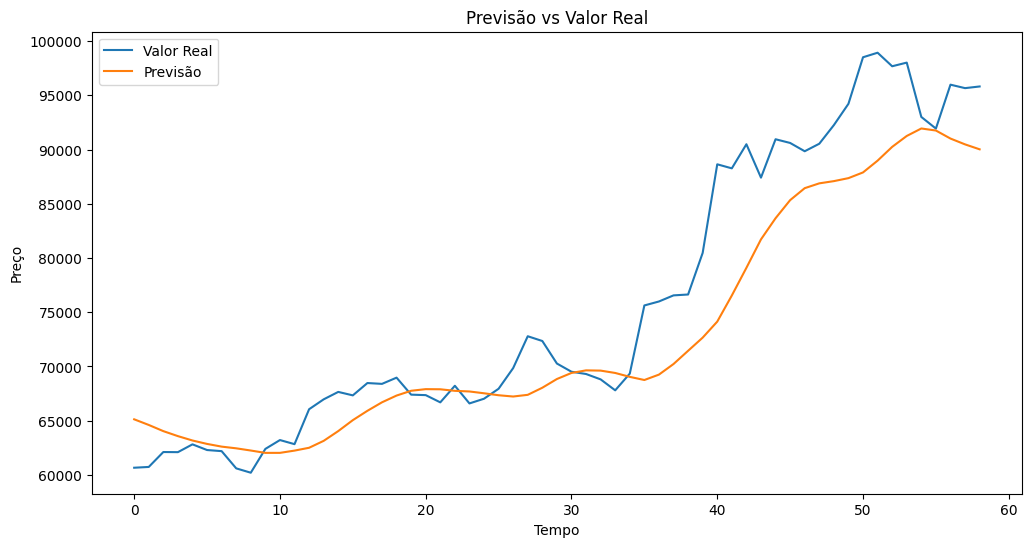

In [5]:

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# Função para avaliar o modelo
def evaluate_and_visualize(model, X_test, Y_test, scaler):
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(np.concatenate([predictions, np.zeros((len(predictions), 2))], axis=1))[:, 0]
    Y_test = scaler.inverse_transform(np.concatenate([Y_test.reshape(-1, 1), np.zeros((len(Y_test), 2))], axis=1))[:, 0]

    # Cálculo das métricas
    rmse = math.sqrt(mean_squared_error(Y_test, predictions))
    mae = mean_absolute_error(Y_test, predictions)
    print(f"RMSE: {rmse}, MAE: {mae}")

    # Visualização
    plt.figure(figsize=(12, 6))
    plt.plot(Y_test, label='Valor Real')
    plt.plot(predictions, label='Previsão')
    plt.xlabel('Tempo')
    plt.ylabel('Preço')
    plt.title('Previsão vs Valor Real')
    plt.legend()
    plt.show()

# Avaliação e visualização
evaluate_and_visualize(model, X_test, Y_test, scaler)
